In [2]:
!pip3 install keras tensorflow seaborn scikit-learn plotly scipy numpy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#import streamlit as st
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image

fashion_df = pd.read_csv("./data/무신사의류데이터.csv")
fashion_df




,Unnamed: 0,key,매칭이미지주소,브랜드이름,제품명,가격,성별,카테고리
0,0,3627500,//image.msscdn.net/images/goods_img/20231013/3...,스키즘 인듀싱,OVERSIZED CAR COAT,"304,200원",MAN,비즈니스캐주얼
1,1,3438649,//image.msscdn.net/images/goods_img/20230801/3...,넌블랭크,캐시미어 블렌드 루즈 핏 하프 집업 칼라 니트_CHARCOAL,"119,900원",MAN,비즈니스캐주얼
2,2,3511511,//image.msscdn.net/images/goods_img/20230829/3...,어반드레스,Pintuck Jar pants GREY,"32,300원",MAN,비즈니스캐주얼
3,3,3418135,//image.msscdn.net/images/goods_img/20230720/3...,마즈,실버 플랫 베이직 반지 4mm,"34,000원",MAN,비즈니스캐주얼
4,4,2991371,//image.msscdn.net/images/goods_img/20221220/2...,마즈,써지컬 라인 텍스쳐 반지,"26,000원",MAN,비즈니스캐주얼
...,...,...,...,...,...,...,...,...
13875,3378,2871705,//image.msscdn.net/images/goods_img/20221018/2...,브이투,70101 비건레더 무스탕_블랙,"126,650원",MAN,댄디
13876,3381,2815340,//image.msscdn.net/images/goods_img/20220923/2...,무신사 스탠다드,아란 케이블 크루 넥 니트 [미디엄 그레이],"71,890원",MAN,댄디
13877,3383,2880427,//image.msscdn.net/images/goods_img/20221020/2...,데이,핸드메이드 맥코트_BLACK,"199,900원",MAN,댄디
13878,3385,2671322,//image.msscdn.net/images/goods_img/20220719/2...,모드나인,Way Out - MOD7s,"81,750원",MAN,댄디


In [26]:
fashion_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

fashion_df.head()

,key,매칭이미지주소,브랜드이름,제품명,가격,성별,카테고리
0,3627500,//image.msscdn.net/images/goods_img/20231013/3...,스키즘 인듀싱,OVERSIZED CAR COAT,"304,200원",MAN,비즈니스캐주얼
1,3438649,//image.msscdn.net/images/goods_img/20230801/3...,넌블랭크,캐시미어 블렌드 루즈 핏 하프 집업 칼라 니트_CHARCOAL,"119,900원",MAN,비즈니스캐주얼
2,3511511,//image.msscdn.net/images/goods_img/20230829/3...,어반드레스,Pintuck Jar pants GREY,"32,300원",MAN,비즈니스캐주얼
3,3418135,//image.msscdn.net/images/goods_img/20230720/3...,마즈,실버 플랫 베이직 반지 4mm,"34,000원",MAN,비즈니스캐주얼
4,2991371,//image.msscdn.net/images/goods_img/20221220/2...,마즈,써지컬 라인 텍스쳐 반지,"26,000원",MAN,비즈니스캐주얼


Total number of products :  13880
Total number of unique subcategories :  5
Total number of unique gender types :  3


/var/folders/pb/bst_vt0n5w90nsb69j8pk8240000gp/T/ipykernel_15079/2374879995.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels())


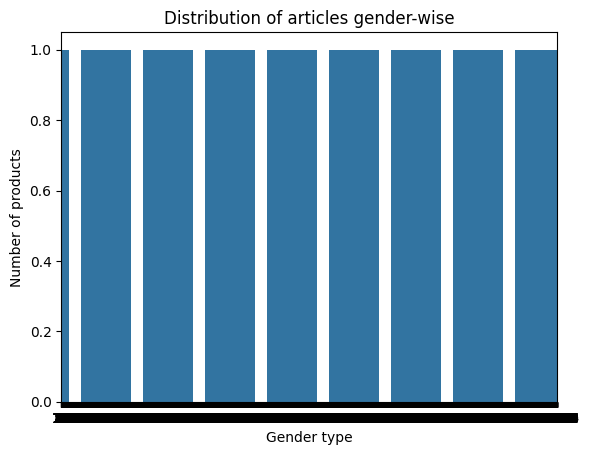

1905
2627
2152
2307
2707
2182


In [27]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["카테고리"].nunique())
print("Total number of unique gender types : ", fashion_df["성별"].nunique())

fashion_df['성별'].unique()

fashion_df['성별'] = fashion_df['성별'].str.lower().map({'woman': 0, 'man': 1})

fashion_df['성별'].value_counts()

plot = sns.countplot(fashion_df["성별"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

fashion_df["성별"].value_counts()

business_men = fashion_df[(fashion_df["카테고리"] == "비즈니스캐주얼") & (fashion_df['성별'] == 1)]
business_women = fashion_df[(fashion_df["카테고리"] == "비즈니스캐주얼") & (fashion_df['성별'] == 0)]
dandy_men = fashion_df[fashion_df["카테고리"] == "댄디"]
romantic_women = fashion_df[fashion_df["카테고리"] == "로맨틱"]
street_men = fashion_df[fashion_df["카테고리"] == "스트릿"]
casual_women =  fashion_df[fashion_df["카테고리"] == "캐주얼"]

import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import scipy

print(len(business_men))
print(len(street_men))
print(len(dandy_men))
print(len(business_women))
print(len(casual_women))
print(len(romantic_women))




In [30]:
import os

img_width, img_height = 224, 224
train_data_dir = "./images/"
epochs = 50
batch_size = 32

def extract_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')

    # Get the list of subdirectories (categories)
    categories = sorted(os.listdir(train_data_dir))

    for category in categories:
        category_dir = os.path.join(train_data_dir, category)
        print(f"Extracting features for category: {category}")

        Itemcodes = []
        generator = datagen.flow_from_directory(
            category_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False
        )

        # Calculate the number of samples in the generator
        num_samples = len(generator.filenames)

        for i in generator.filenames:
            Itemcodes.append(i[(i.find("/")+1):i.find(".")])

        # Use model.predict instead of predict_generator
        extracted_features = model.predict(generator, verbose=1)
        print("Shape of extracted features:", extracted_features.shape)

        # Reshape the features
        extracted_features = extracted_features.reshape((num_samples, -1))

        # Save features and item codes for each category
        np.save(open(f'./{category}_ResNet_features.npy', 'wb'), extracted_features)
        np.save(open(f'./{category}_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Extracting features for category: business_men
Found 1902 images belonging to 1 classes.
60/60 [==============================] - 35s 585ms/step
Shape of extracted features: (1902, 7, 7, 2048)
Extracting features for category: business_women
Found 2307 images belonging to 1 classes.
73/73 [==============================] - 42s 575ms/step
Shape of extracted features: (2307, 7, 7, 2048)
Extracting features for category: casual_women
Found 2707 images belonging to 1 classes.
85/85 [==============================] - 55s 652ms/step
Shape of extracted features: (2707, 7, 7, 2048)
Extracting features for category: dandy_men
Found 2150 images belonging to 1 classes.
68/68 [==============================] - 40s 583ms/step
Shape of extracted features: (2150, 7, 7, 2048)
Extracting features for category: romantic_women
Found 2177 images belonging to 1 classes.
69/69 [==============================] - 40s 575ms/step
Shape of extracted features: (2177, 7, 7, 2048)
Extracting features for category: 

In [68]:
extracted_features = np.load('./business_men_ResNet_features.npy')
Productids = np.load('./business_men_ResNet_feature_product_ids.npy')
business_men = pd.read_csv('./data/무신사남성비즈니스.csv')
df_Productids = list(business_men['key'])
Productids = list(Productids)
print(business_men.iloc[0].values)

[0 3627500
 '//image.msscdn.net/images/goods_img/20231013/3627500/3627500_16972035181511_220.jpg'
 '스키즘 인듀싱' 'OVERSIZED CAR COAT' '304,200원' 'MAN' '비즈니스캐주얼']


In [36]:

def get_similar_products_cnn(product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print(indices)
    print("="*20, "input product image", "="*20)
    ip_row = business_men[['매칭이미지주소','제품명']].loc[business_men['key']==Productids[indices[0]]]
    # 이미지 URL이 "https:"로 시작하지 않으면 추가
    #print(ip_row.head())
    for indx, row in ip_row.iterrows():
        if not row['매칭이미지주소'].startswith("https:"):
            row['매칭이미지주소'] = "https:" + row['매칭이미지주소']
        display(Image(url=row['매칭이미지주소'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['제품명'])
        print('Image URL:', row['매칭이미지주소'])
        print('Product Title:', row['제품명'])
    print("\n","="*20, "Recommended products", "="*20)

    for i in range(1,len(indices)):
        rows = business_men[['매칭이미지주소','제품명']].loc[business_men['제품명']==Productids[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['매칭이미지주소'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['제품명'])
            print('Euclidean Distance from input image:', pdists[i])

get_similar_products_cnn('image_0_image', 5)

[   0 1139 1246 1477  745]
==================== input product image ====================

 ==================== Recommended products ====================


==================== input product image ====================

 ==================== Recommended products ====================


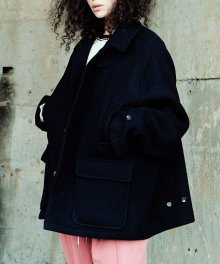

Product Title:  OVERSIZED CAR COAT
Euclidean Distance from input image: 1.57284e-05


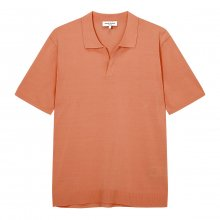

Product Title:  오픈 카라 숏 슬리브 니트
Euclidean Distance from input image: 37.953003


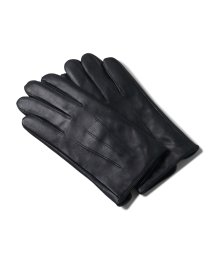

Product Title:  램스킨 터치 글러브 [블랙]
Euclidean Distance from input image: 38.906746


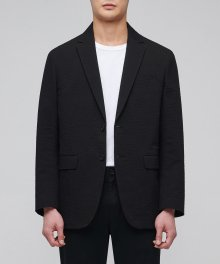

Product Title:  시어서커 블레이저 [블랙]
Euclidean Distance from input image: 39.352444


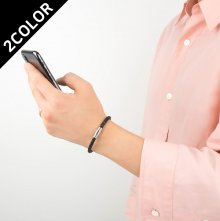

Product Title:  [남여공용] 써지컬 자석유닛 2컬러 가죽팔찌 / GHMB-166
Euclidean Distance from input image: 39.36461


In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import Image, display

# ResNet을 통해 추출한 제품 이미지의 특징
extracted_features = np.load('./business_men_ResNet_features.npy')

# 각 제품에 대한 고유한 ID 리스트
Productids = np.load('./business_men_ResNet_feature_product_ids.npy')
business_men = pd.read_csv('./data/무신사남성비즈니스.csv')
df_Productids = list(business_men['key'])
Productids = list(Productids)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_with_titles(images_and_titles):
    for image_path, title in images_and_titles:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        plt.show()

def get_similar_products_cnn(product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1, -1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    print("=" * 20, "input product image", "=" * 20)
    print("\n", "=" * 20, "Recommended products", "=" * 20)
    for i in range(0, len(indices)):
        row = business_men[['매칭이미지주소', '제품명']].iloc[int(Productids[indices[i]].split('_')[1])]
        # 이미지 URL이 "https:"로 시작하지 않으면 추가
        if not row['매칭이미지주소'].startswith("https:"):
            row['매칭이미지주소'] = "https:" + row['매칭이미지주소']
        display(Image(url=row['매칭이미지주소'], width=224, height=224, embed=True))
        print('Product Title: ', row['제품명'])
        print('Euclidean Distance from input image:', pdists[i])

# 함수를 호출하여 유사한 제품을 찾고 이미지와 제목을 출력
get_similar_products_cnn('image_0_image', 5)

In [46]:
# ImageDataGenerator 설정
datagen = ImageDataGenerator(rescale=1. / 255)

# generator 생성 및 데이터 출력
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,  # 클래스 정보를 읽지 않음
    shuffle=False
)

# 데이터 출력
for data_batch in generator:
    print('Data batch shape:', data_batch.shape)
    break


Found 0 images belonging to 0 classes.
Data batch shape: (0, 224, 224, 3)


In [38]:
def get_similar_products_cnn(product_id, num_results, fashion_df, extracted_features_dict, product_ids_dict):
    gender_mapping = {'MAN': 'man', 'WOMAN': 'woman'}  # 성별에 대한 매핑
    category_mapping = {'비즈니스캐주얼': 'business', '댄디': 'dandy', '로맨틱': 'romantic', '스트릿': 'street', '캐주얼': 'casual'}

    gender = fashion_df[fashion_df['id'] == int(product_id)]['성별'].values[0]
    category = fashion_df[fashion_df['id'] == int(product_id)]['카테고리'].values[0]

    gender_str = gender_mapping.get(gender, None)
    category_str = category_mapping.get(category, None)

    if gender_str is None or category_str is None:
        print("올바르지 않은 성별 또는 카테고리입니다.")
        return

    key = f"{gender_str}_{category_str}"
    extracted_features = extracted_features_dict.get(key, None)
    Productids = product_ids_dict.get(key, None)

    if extracted_features is None or Productids is None or len(Productids) == 0:
        print("주어진 성별 및 카테고리에 대한 제품을 찾을 수 없습니다.")
        return

    Productids = list(Productids)
    doc_id = Productids.index(product_id)

    if doc_id >= len(Productids):
        print(f"잘못된 제품 ID입니다: {product_id}")
        return

    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1, -1))
    indices = np.argsort(pairwise_dist.flatten())[:num_results]
    pdists = np.sort(pairwise_dist.flatten())[:num_results]
    print("=" * 20, "입력 제품 이미지", "=" * 20)
    ip_row = fashion_df[['매칭이미지주소', '브랜드이름', '제품명', '가격']].loc[fashion_df['id'] == int(Productids[indices[0]])]
    
    # 입력 제품 정보 표시
    for indx, row in ip_row.iterrows():
        display(Image(url=row['매칭이미지주소'], width=224, height=224, embed=True))
        print(f"브랜드: {row['브랜드이름']}")
        print(f"제품명: {row['제품명']}")
        print(f"가격: {row['가격']}")
    
    print("\n", "=" * 20, "추천 제품", "=" * 20)
    
    # 추천 제품 표시
    for i in range(1, len(indices)):
        rows = fashion_df[['매칭이미지주소', '브랜드이름', '제품명', '가격']].loc[fashion_df['id'] == int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['매칭이미지주소'], width=224, height=224, embed=True))
            print(f"브랜드: {row['브랜드이름']}")
            print(f"제품명: {row['제품명']}")
            print(f"가격: {row['가격']}")
            print('입력 이미지로부터의 유클리드 거리:', pdists[i])


In [39]:

get_similar_products_cnn('3627500', 5, fashion_df, extracted_features_dict, product_ids_dict)


NameError: name 'extracted_features_dict' is not defined

In [ ]:
st.write("""
         ## Visual Similarity based Recommendation
         """
         )


user_input1 = st.text_input("Enter the item id")
user_input2 = st.text_input("Enter number of products to be recommended")


button = st.button('Generate recommendations')
if button:
    get_similar_products_cnn(str(user_input1), int(user_input2))

Index(['Unnamed: 0', 'key', '매칭이미지주소', '브랜드이름', '제품명', '가격', '성별', '카테고리'], dtype='object')


/var/folders/pb/bst_vt0n5w90nsb69j8pk8240000gp/T/ipykernel_15079/714982693.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels())


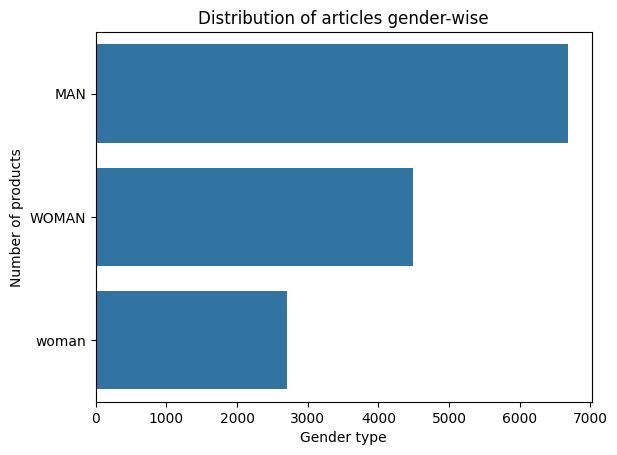

성별
MAN      6684
WOMAN    4489
woman    2707
Name: count, dtype: int64
Found 13869 images belonging to 6 classes.


/var/folders/pb/bst_vt0n5w90nsb69j8pk8240000gp/T/ipykernel_15079/714982693.py:62: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, num_samples // batch_size)


KeyboardInterrupt: 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
from IPython.display import display, Image

# fashion_df 열 이름 확인
print(fashion_df.columns)


# '성별'에 따른 카운트 플롯
plot = sns.countplot(fashion_df["성별"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

# '성별' 값 카운트
print(fashion_df["성별"].value_counts())

# 각 카테고리 및 성별에 대한 데이터 프레임 생성
business_men = fashion_df[(fashion_df["카테고리"] == "비즈니스캐주얼") & (fashion_df['성별'] == 1)]
business_women = fashion_df[(fashion_df["카테고리"] == "비즈니스캐주얼") & (fashion_df['성별'] == 0)]
dandy_men = fashion_df[fashion_df["카테고리"] == "댄디"]
romantic_women = fashion_df[fashion_df["카테고리"] == "로맨틱"]
street_men = fashion_df[fashion_df["카테고리"] == "스트릿"]
casual_women = fashion_df[fashion_df["카테고리"] == "캐주얼"]

# 이미지 데이터 디렉토리 설정
img_width, img_height = 224, 224
train_data_dir = "./images/"

nb_train_samples = 13879
epochs = 50
batch_size = 128

# 함수 수정
def extract_features_and_save_single_dir(train_data_dir, num_samples, save_prefix):
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    for i in generator.filenames:
        Itemcodes.append(i[:i.find(".")])
    extracted_features = model.predict_generator(generator, num_samples // batch_size)
    extracted_features = extracted_features.reshape((num_samples, 100352))

    np.save(open(f'./model/{save_prefix}_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open(f'./model/{save_prefix}_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

# 함수 호출
extract_features_and_save_single_dir(train_data_dir, nb_train_samples, 'All')

# get_similar_products_cnn 함수도 수정
def get_similar_products_cnn(product_id, num_results, fashion_df, extracted_features_dict, product_ids_dict):
    gender_mapping = {'man': 'MAN', 'woman': 'WOMAN'}  # 성별에 대한 매핑
    category_mapping = {'business': '비즈니스캐주얼', 'dandy': '댄디', 'romantic': '로맨틱', 'street': '스트릿', 'casual': '캐주얼'}

    gender = fashion_df[fashion_df['id'] == int(product_id)]['성별'].values[0]
    category = fashion_df[fashion_df['id'] == int(product_id)]['카테고리'].values[0]

    gender_str = gender_mapping.get(gender, None)
    category_str = category_mapping.get(category, None)

    if gender_str is None or category_str is None:
        print("Invalid gender or category.")
        return

    key = f"{gender_str}_{category_str}"
    extracted_features = extracted_features_dict.get(key, None)
    Productids = product_ids_dict.get(key, None)

    if extracted_features is None or Productids is None:
        print("Invalid gender or category.")
        return

    Productids = list(Productids)
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1, -1))
    indices = np.argsort(pairwise_dist.flatten())[:num_results]
    pdists = np.sort(pairwise_dist.flatten())[:num_results]
    print("=" * 20, "Input product image", "=" * 20)
    ip_row = fashion_df[['매칭이미지주소', '브랜드이름', '제품명', '가격']].loc[fashion_df['id'] == int(Productids[indices[0]])]
    
    # Display input product information
    for indx, row in ip_row.iterrows():
        display(Image(url=row['매칭이미지주소'], width=224, height=224, embed=True))
        print(f"Brand: {row['브랜드이름']}")
        print(f"Product Name: {row['제품명']}")
        print(f"Price: {row['가격']}")
    
    print("\n", "=" * 20, "Recommended products", "=" * 20)
    
    # Display recommended products
    for i in range(1, len(indices)):
        rows = fashion_df[['매칭이미지주소', '브랜드이름', '제품명', '가격']].loc[fashion_df['id'] == int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['매칭이미지주소'], width=224, height=224, embed=True))
            print(f"Brand: {row['브랜드이름']}")
            print(f"Product Name: {row['제품명']}")
            print(f"Price: {row['가격']}")
            print('Euclidean Distance from input image:', pdists[i])

# 함수 호출
get_similar_products_cnn('3627500', 5, fashion_df, extracted_features_dict, product_ids_dict)
